# Train VGG-Face architecture using our own dataset
## Fine-Tuning Pre-Trained Deep Neural Network

In this lab, we want to use the pre-trained network and then re-train only the final layers to finish new task.
Basic theory we used is the same as we learnt from [lab8](https://github.com/sdrangan/introml/blob/master/cnn/lab08_fine_tune_partial.ipynb).

*This dataset comes from of one of our undergradute matlab projects*
To begin with, we chose ten celebrities from VGG face dataset and found faces of them on the Internet.
Our own dataset has 1496 photos of 10 different celebrities.
![Dataset](Dataset.PNG)

Name of the celebrities are:
* Bingbing Fan
* Jack Ma
* Jean Reno
* Luc Besson
* Mark Zuckerberg
* Quentin Tarantino
* Steve Jobs
* Taylor Swift
* Yifei Liu
* Yun Fat Chow

The size of our databset is over 100 files so you can download it from [here](https://drive.google.com/a/nyu.edu/file/d/1hgcajyL_qAPl61nkU1NVft-JNaw6L9Lo/view?usp=sharing).

We created [this](https://github.com/skylarhuang/ML_project/blob/master/create_test.ipynb) file to separate them into trainning and test sets. 

Test set has 10 pictures of each celebrity and the left photos are still in the training set.


## In this jupyter notebook, we did:

* Load vgg-face 
* Fine tunning the last layers
* Import our own dataset
* Train the customized model
* Plot errors
* Load dataset again, but randomly rotate or filp the photos
* Train the customized model again

First let's import packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import math
import copy
%matplotlib inline

In [2]:
# TODO
import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential

Using TensorFlow backend.


Now we clear Keras session as we always did.

In [3]:
K.clear_session()

Because we are using `MaxPooling2D` here.

We need to sets the value of the data format convention before use the model.

In [MaxPooling2D](https://keras.io/layers/pooling/), data format are classified into to kinds of shapes:

* If data_format='channels_last': 
    
    4D tensor with shape: (batch_size, rows, cols, channels)
    
* If data_format='channels_first': 
    
    4D tensor with shape: (batch_size, channels, rows, cols)
    
We already know that Vgg-face takes data in shape (224,224,3), the RGB channel is on the last axis, so here we choose the *data_format* to be 'channels_last'.

Also, set the input shape.

In [4]:
K.set_image_data_format( 'channels_last' ) 
nrow = 224
ncol = 224

## Load Vgg Face

Import the Vgg Face model.

In [5]:
vggface = VGGFace(model='vgg16') 
vggface.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

##  Fine tunning the last layers

Referencing one code block from the [this](https://github.com/rcmalli/keras-vggface) page.

In this picture, we check the aechitecture of VGG Face network.

<img src="https://image.slidesharecdn.com/tfmandreavideoretrievalofspecificpersonsinspecificlocations-160920130647/95/video-retrieval-of-specific-persons-in-specific-locations-23-638.jpg?cb=1474377027" height="150" width="250">

So, if we want to fine-tune the last few layers to train our data set, we need the output of the last convolution block.

Search for that output layer in the model summary above, name of the output layer should be *pool5 (MaxPooling2D)*.

And we find tuned the layers below to use our own dataset.

We created two more same model for future use.

In [6]:
#custom parameters
# 10 Names, 10 classes
nb_class = 10
hidden_dim = 512

vgg_notop = VGGFace(include_top=False, input_shape=(224, 224, 3))

last_layer = vggface.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)

custom_vgg_model = Model(vggface.input, out)

# Create two more models for future use
custom_vgg_model2 = Model(vggface.input, out)
custom_vgg_model3 = Model(vggface.input, out)

custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

## Import our own dataset

Now let's import our own dataset.

The code below creates an `ImageDataGenerator` for the training and testing data. 

Because we have 10 classes, the class mode shoule be `sparse`.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 8

train_data_dir = './face_train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1396 images belonging to 10 classes.


In [8]:
test_data_dir = './face_test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 100 images belonging to 10 classes.


Since we don't want the predict result to be index, as we did before, we list their name to be the predict result.

So how can we find the names?

Since photos are saved under the folders named by the celebrity's name, we list the folders and convert the folder's name into *textFileNames*, to be the label.

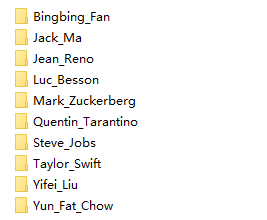

In [9]:
import os
datasetDescriptor = './face_train'
textFileNames = os.listdir(datasetDescriptor)

print(textFileNames)

['Bingbing_Fan', 'Jack_Ma', 'Jean_Reno', 'Luc_Besson', 'Mark_Zuckerberg', 'Quentin_Tarantino', 'Steve_Jobs', 'Taylor_Swift', 'Yifei_Liu', 'Yun_Fat_Chow']


Print some photos in the training set.

We import some code block in [lab8](https://github.com/sdrangan/introml/blob/master/cnn/lab08_fine_tune_partial.ipynb) to finish it.

In [10]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

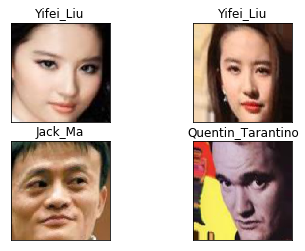

In [11]:
batch_shape = (batch_size,custom_vgg_model.input_shape[1] , 
               custom_vgg_model.input_shape[2], 
               custom_vgg_model.input_shape[3])
X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 4        
for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[y[i]])
    plt.title(title)

##  Train the customized model

Then we compiled the model and trained it using our own dataset.

For multi classification, the loss function we chose 'sparse_categorical_crossentropy', all loss functions are listed in [here](https://keras.io/losses/) and we thought the one we used is the most suitable.

For optimizer, we used 'SGD', others are listed [here](https://keras.io/optimizers/).
SGD is Stochastic gradient descent optimizer. It includes support for momentum, learning rate decay, and Nesterov momentum.

Arguments:
* lr: float >= 0. Learning rate.
* momentum: float >= 0. Parameter updates momentum.
* decay: float >= 0. Learning rate decay over each update.
* nesterov: boolean. Whether to apply Nesterov momentum.

In [12]:
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

In [13]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 5

custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
174/174 [==============================] - 40s 231ms/step - loss: 2.2262 - acc: 0.2744 - val_loss: 2.0928 - val_acc: 0.3125
Epoch 2/5
174/174 [==============================] - 37s 212ms/step - loss: 0.8781 - acc: 0.7672 - val_loss: 0.2568 - val_acc: 0.9375
Epoch 3/5
174/174 [==============================] - 37s 211ms/step - loss: 0.1181 - acc: 0.9670 - val_loss: 0.2160 - val_acc: 0.9167
Epoch 4/5
174/174 [==============================] - 37s 212ms/step - loss: 0.0569 - acc: 0.9813 - val_loss: 0.0869 - val_acc: 0.9792
Epoch 5/5
174/174 [==============================] - 37s 212ms/step - loss: 0.0326 - acc: 0.9907 - val_loss: 0.1213 - val_acc: 0.9583


The result is >98% accuracy and >95% validate accuracy.

## Lets find some errors

We used some thoughts in the bonus part of [lab8](https://github.com/sdrangan/introml/blob/master/cnn/lab08_fine_tune_partial.ipynb).

But since our model is multiclass, and the output shape is: (batchsize multiply no.of class), which is (8 x 10), so each row shows the probability of each class.

Instead of simply use 'yhat != y', we use `y!=np.argmax(yhat,axis=1)` to find the error.

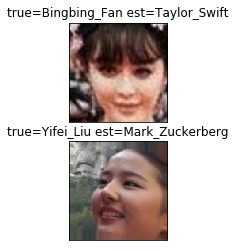

In [14]:
batch_shape = (batch_size,
               custom_vgg_model.input_shape[1],
               custom_vgg_model.input_shape[2],
               custom_vgg_model.input_shape[3])

X = np.zeros(batch_shape)
y = np.zeros(batch_size)

Xerr = np.zeros(batch_shape)
yerr = np.zeros(batch_size)
ytr = np.zeros(batch_size)

nerr = 0
maxerr = 2

while nerr <= maxerr:
    # Generate a mini-batch X,y from the test_generator.next() method
    X,y = test_generator.next()
    
    # Predict the labels using the model.predict and compute a predicted label yhat
    yhat = custom_vgg_model.predict(X)

    # Find the locations i where yhat[i] != y[i].
    # Yhat has a shape of no.ofclass * batchsize
    # So we use axis to locate one picture
    # And use argmax to find the index
    err = np.where(y != np.argmax(yhat,axis=1))[0]
    
    # Save errors 
    for i in range(len(err)):
        ind = err[i]
        Xerr[nerr+i,:,:,:] = X[ind,:,:,:]
        yerr[nerr+i] = np.argmax(yhat[ind])
        ytr[nerr+i] = y[ind]
     
    # Keep going through mini-batches until you have four errors.
    nerr = nerr + len(err)

# Print the four error images
for i in range(maxerr):
    plt.subplot(maxerr,1,i+1)
    disp_image(Xerr[i,:,:,:])
    title = ('true='+textFileNames[int(ytr[i])]+
             ' est='+textFileNames[int(yerr[i])])

    plt.title(title)

## Load dataset again, but randomly rotate & flip the photos

Now we are thinking to import some twists to our dataset.

What if the face are rotate by 90 degree? Like you find someone lying on the sofa with their faces staying horizontally to your eyes. Or you try to recognize the face in the CCTV on the street and the cam is crooked, you can only find a crooked face.

Will the result still be good?

We know from [lab8](https://github.com/sdrangan/introml/blob/master/cnn/lab08_fine_tune_partial.ipynb) that : *In addition to the reading the files, the `ImageDataGenerator` creates random deformations of the image to expand the total dataset size.  This is a classic trick that was key in the early deep learning experiments*.

So we add the argument *rotation_range* and *vertical_flip* to add some random edited photos. 

[Keras Documentation of ImageDataGenerator](https://keras.io/preprocessing/image/)

*We only did this to the testing set.
Training set remains the same.*

In [15]:
test_data_dir = './face_test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation 
                                   rotation_range=90,
                                   # Add flip
                                   vertical_flip=True,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 100 images belonging to 10 classes.


Let's print some photos to see the result.

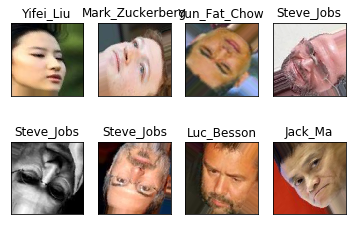

In [16]:
X,y = test_generator.next()
nplot = 8
for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[y[i]])
    plt.title(title)

## Train the customized model again

In [17]:
custom_vgg_model2.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 5

custom_vgg_model2.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
174/174 [==============================] - 37s 215ms/step - loss: 0.0228 - acc: 0.9950 - val_loss: 2.5768 - val_acc: 0.3438
Epoch 2/5
174/174 [==============================] - 37s 212ms/step - loss: 0.0227 - acc: 0.9935 - val_loss: 2.1337 - val_acc: 0.3646
Epoch 3/5
174/174 [==============================] - 37s 211ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 2.6474 - val_acc: 0.3542
Epoch 4/5
174/174 [==============================] - 37s 212ms/step - loss: 0.0182 - acc: 0.9943 - val_loss: 2.1815 - val_acc: 0.3646
Epoch 5/5
174/174 [==============================] - 37s 212ms/step - loss: 0.0044 - acc: 0.9993 - val_loss: 2.5612 - val_acc: 0.4062


The validate acc is <41%.

So let's do it again, but also edit the training set.

In [18]:
train_data_dir = './face_train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation
                                   rotation_range=90,
                                   # Add flip
                                   vertical_flip=True,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 1396 images belonging to 10 classes.


In [19]:
custom_vgg_model3.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

custom_vgg_model3.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
174/174 [==============================] - 37s 214ms/step - loss: 1.4349 - acc: 0.5136 - val_loss: 1.1178 - val_acc: 0.6250
Epoch 2/5
174/174 [==============================] - 37s 212ms/step - loss: 0.9170 - acc: 0.6889 - val_loss: 0.9622 - val_acc: 0.6979
Epoch 3/5
174/174 [==============================] - 37s 215ms/step - loss: 0.7573 - acc: 0.7529 - val_loss: 0.9202 - val_acc: 0.7292
Epoch 4/5
174/174 [==============================] - 37s 212ms/step - loss: 0.6300 - acc: 0.7852 - val_loss: 0.7364 - val_acc: 0.7604
Epoch 5/5
174/174 [==============================] - 37s 212ms/step - loss: 0.5152 - acc: 0.8247 - val_loss: 0.6002 - val_acc: 0.8438


This time the accuracy and validate accuracy are both >82%.

So for testing the rotated and flipped faces, if we still using the same training dataset, with faces straight infront of the camera, the result is OK. The network can correctly identify nearly half the people in the photos. 

But if we add edited training dataset to the model, the result is much better. So if we want to do facial recognition twisted and flipped faces, the better way is to train a new dataset with twisted and flipped samples.